In [1]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc as pm
from matplotlib import rcParams

rcParams['figure.figsize'] = [12, 8]
rcParams['figure.dpi'] = 300

WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [2]:
df = pd.read_csv('data/h1weekly.csv',
                 parse_dates=['Date'],
                 index_col='Date',
                 dtype={'IsCanceled': float})
df.index.freq = 'W-SUN'

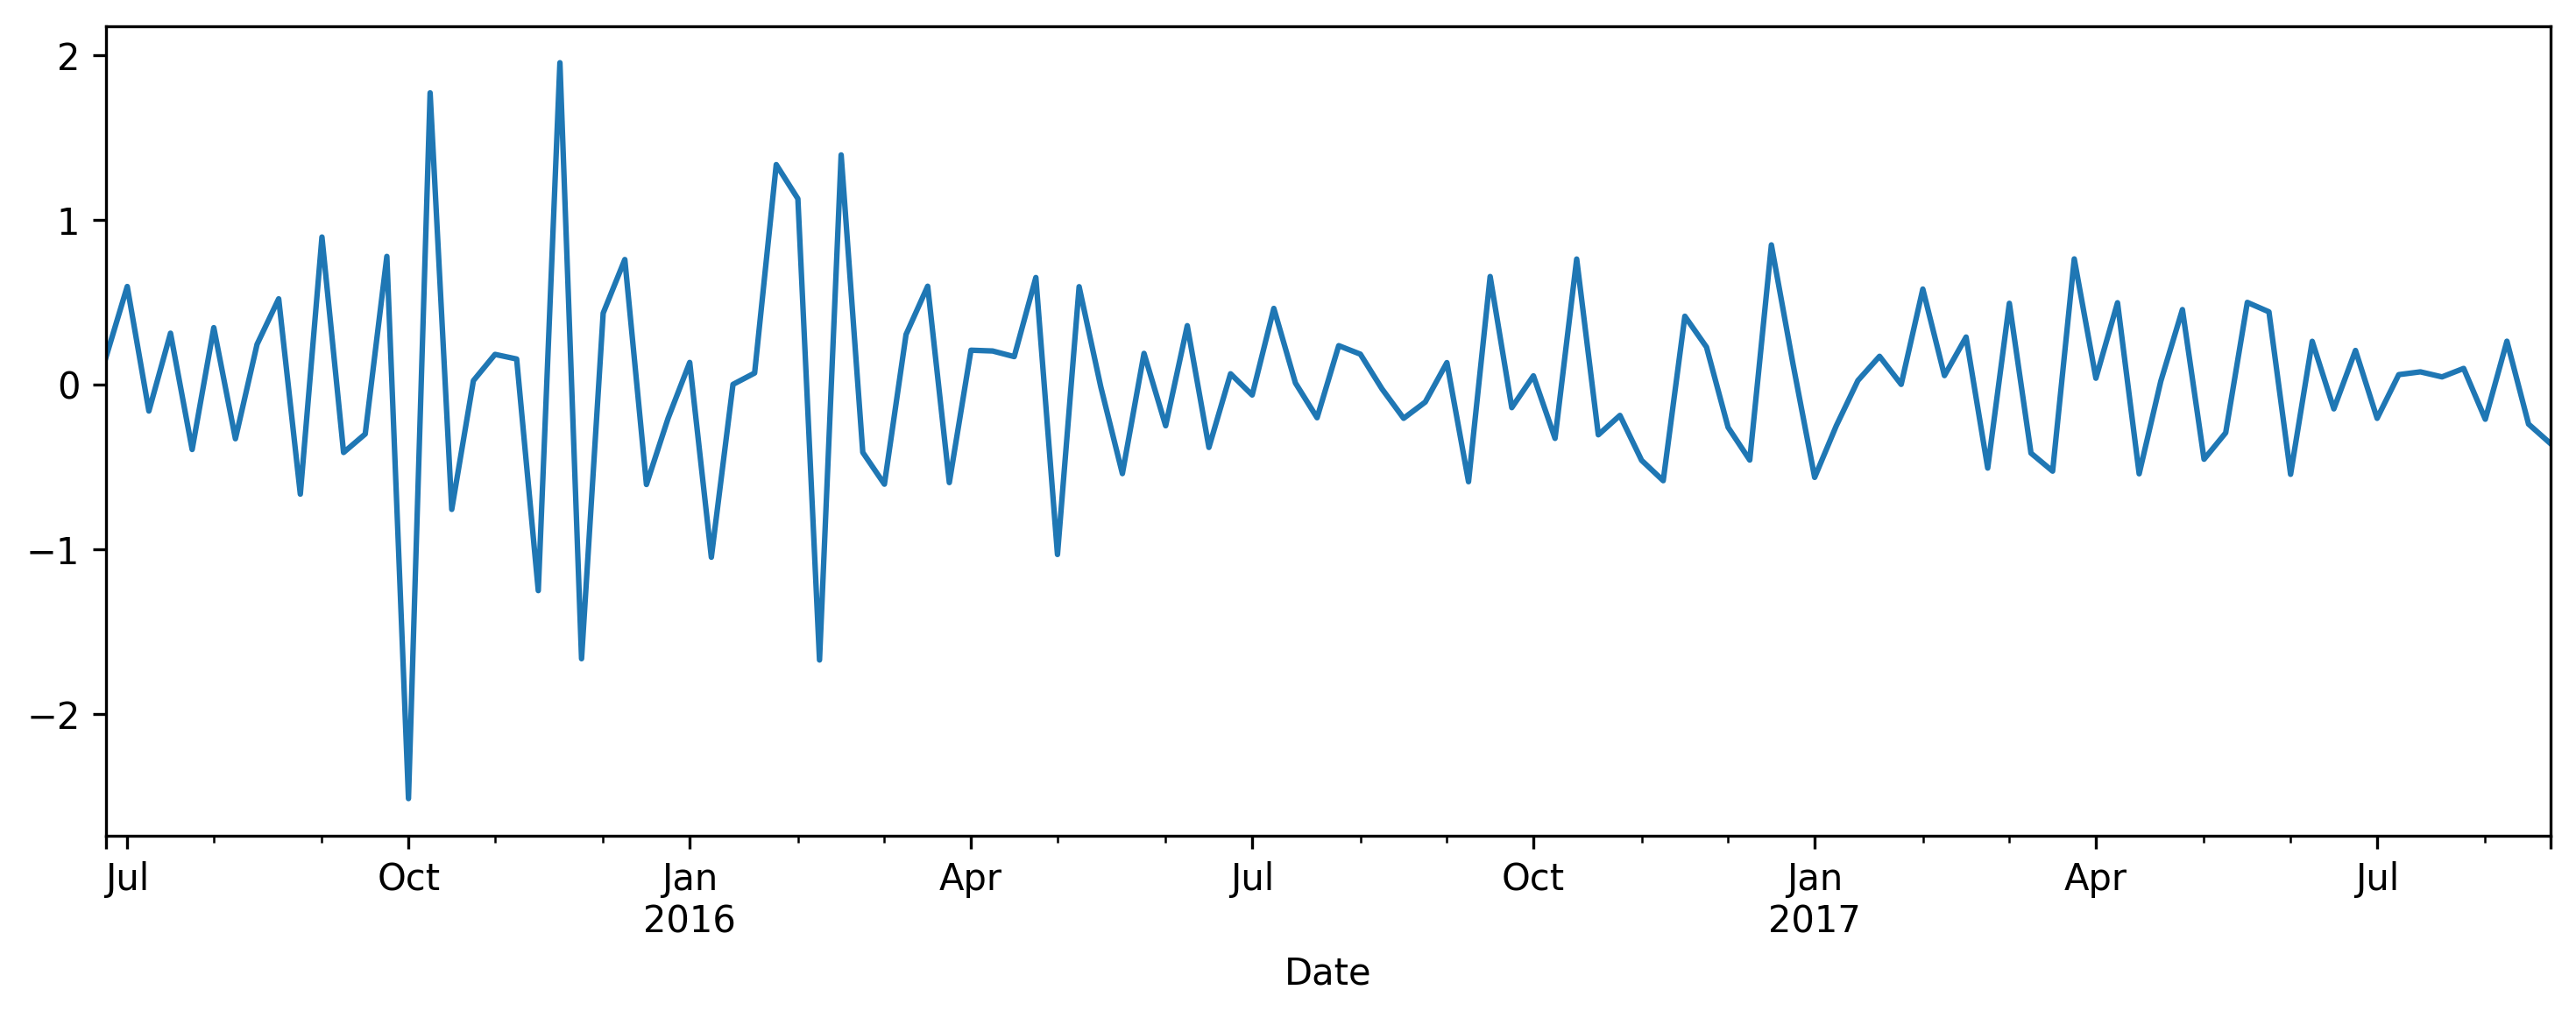

In [3]:
series = pd.Series(np.log(df['IsCanceled'])).diff().dropna()

plt.figure(figsize=(12, 4))
_ = series.plot()

In [4]:
data = series.values

with pm.Model() as model:
    mu = pm.Normal('mu')
    theta = pm.Normal('theta')
    sigma = pm.GaussianRandomWalk('sigma', init_dist=pm.Normal.dist(), steps=len(data) - 1)
    epsilon = pm.Normal("epsilon", sigma=pm.math.abs(sigma))
    obs = pm.Normal('obs', mu=mu + theta * epsilon[:-1] + epsilon[1:], observed=data[1:])
    idata = pm.sample(10_000, chains=4)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu, theta, sigma, epsilon]


Sampling 4 chains for 1_000 tune and 10_000 draw iterations (4_000 + 40_000 draws total) took 658 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
There were 5406 divergences after tuning. Increase `target_accept` or reparameterize.
Chain 0 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.
Chain 1 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.
Chain 2 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.
Chain 3 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.


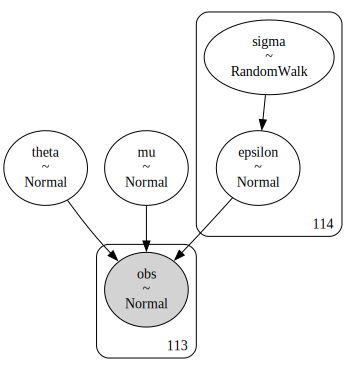

In [5]:
pm.model_to_graphviz(model)

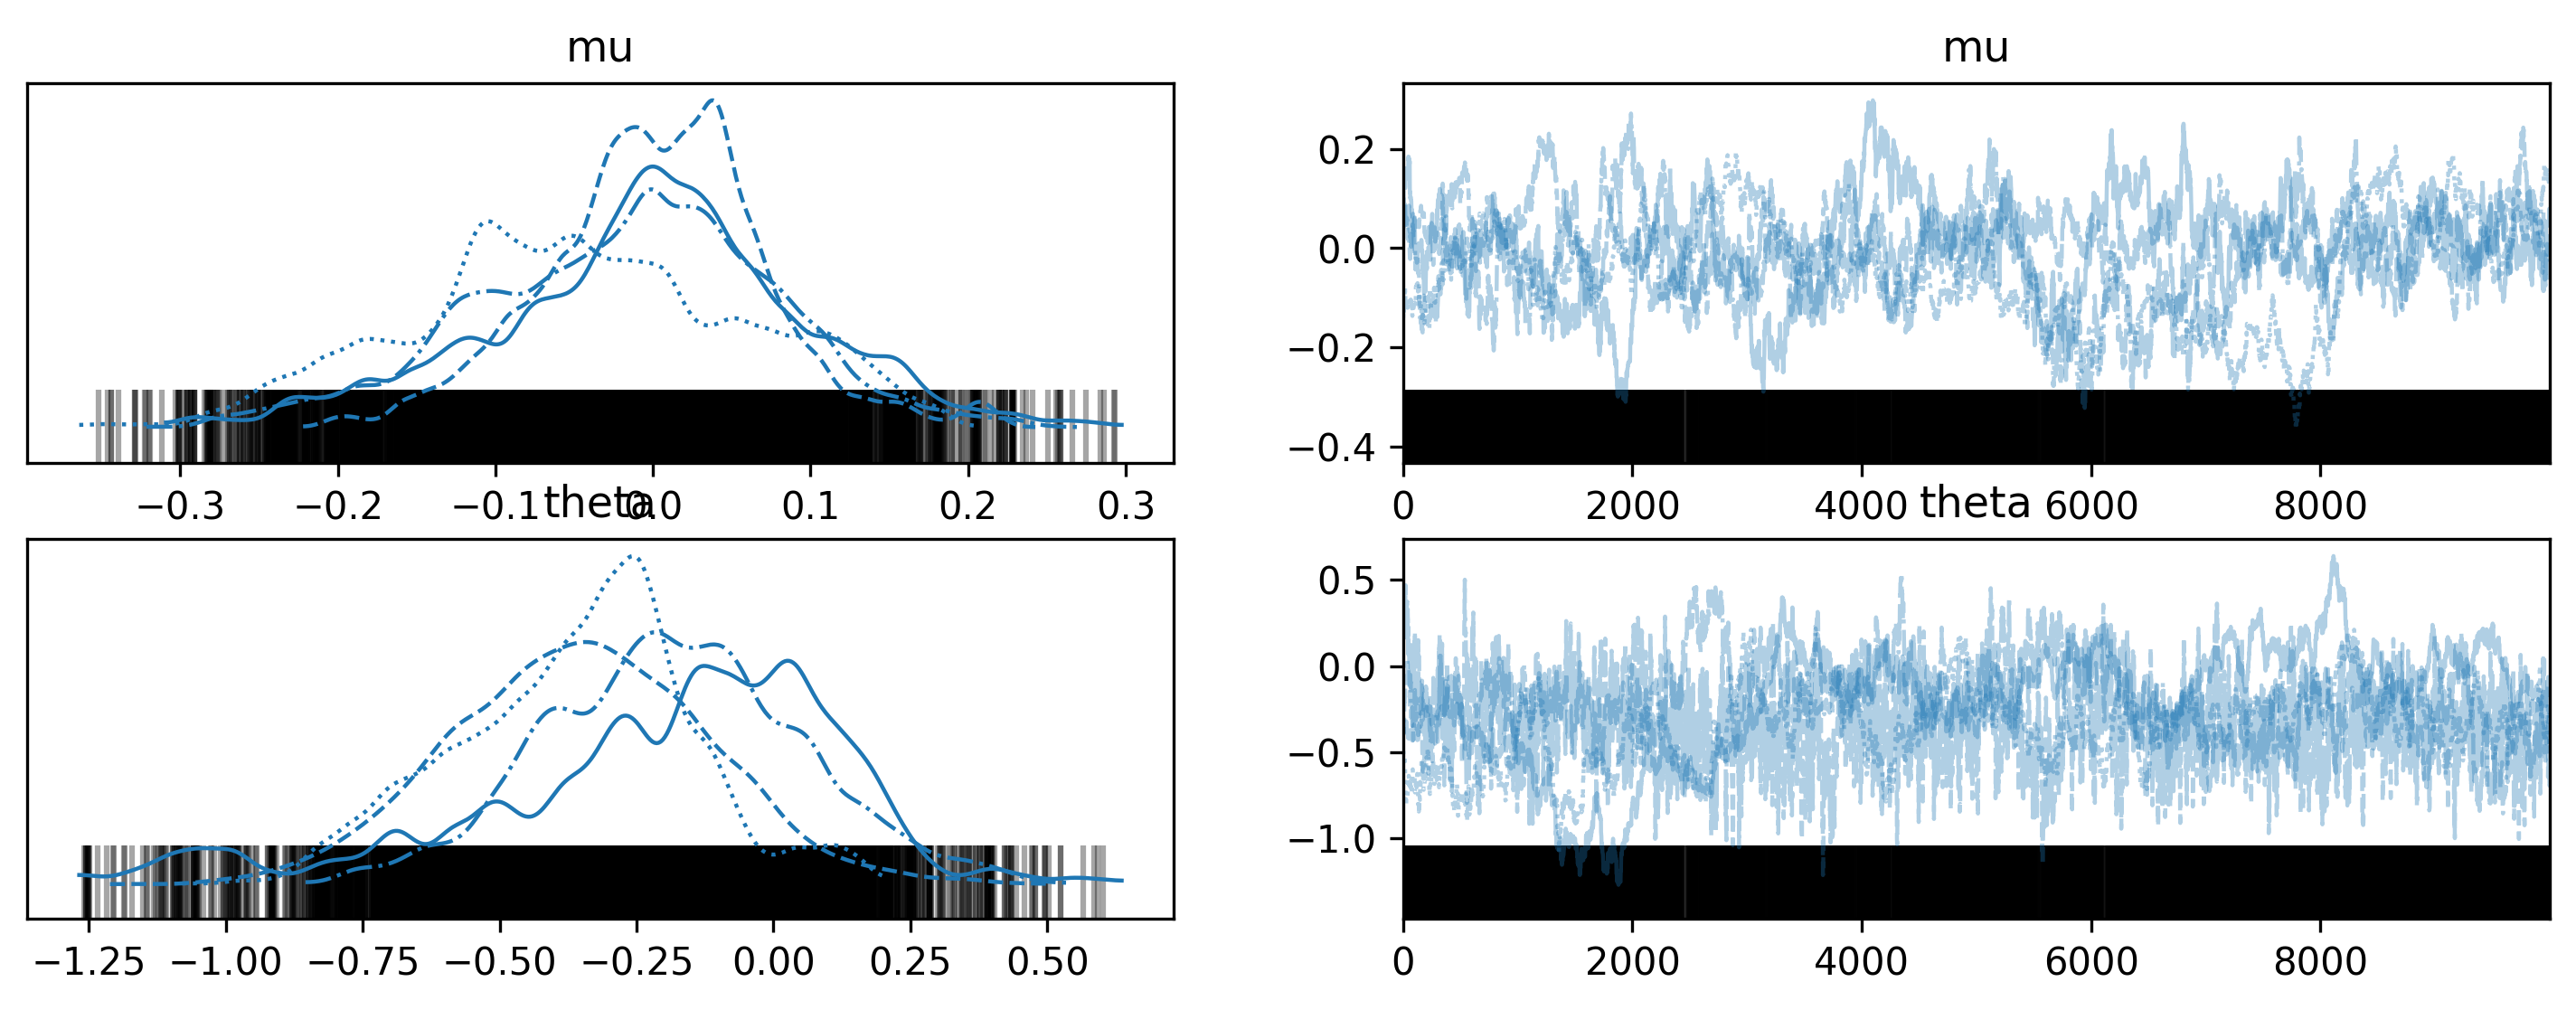

In [9]:
_ = az.plot_trace(idata, var_names=['mu', 'theta'])

In [10]:
with model:
    pm.sample_posterior_predictive(idata, extend_inferencedata=True)

Sampling: [obs]


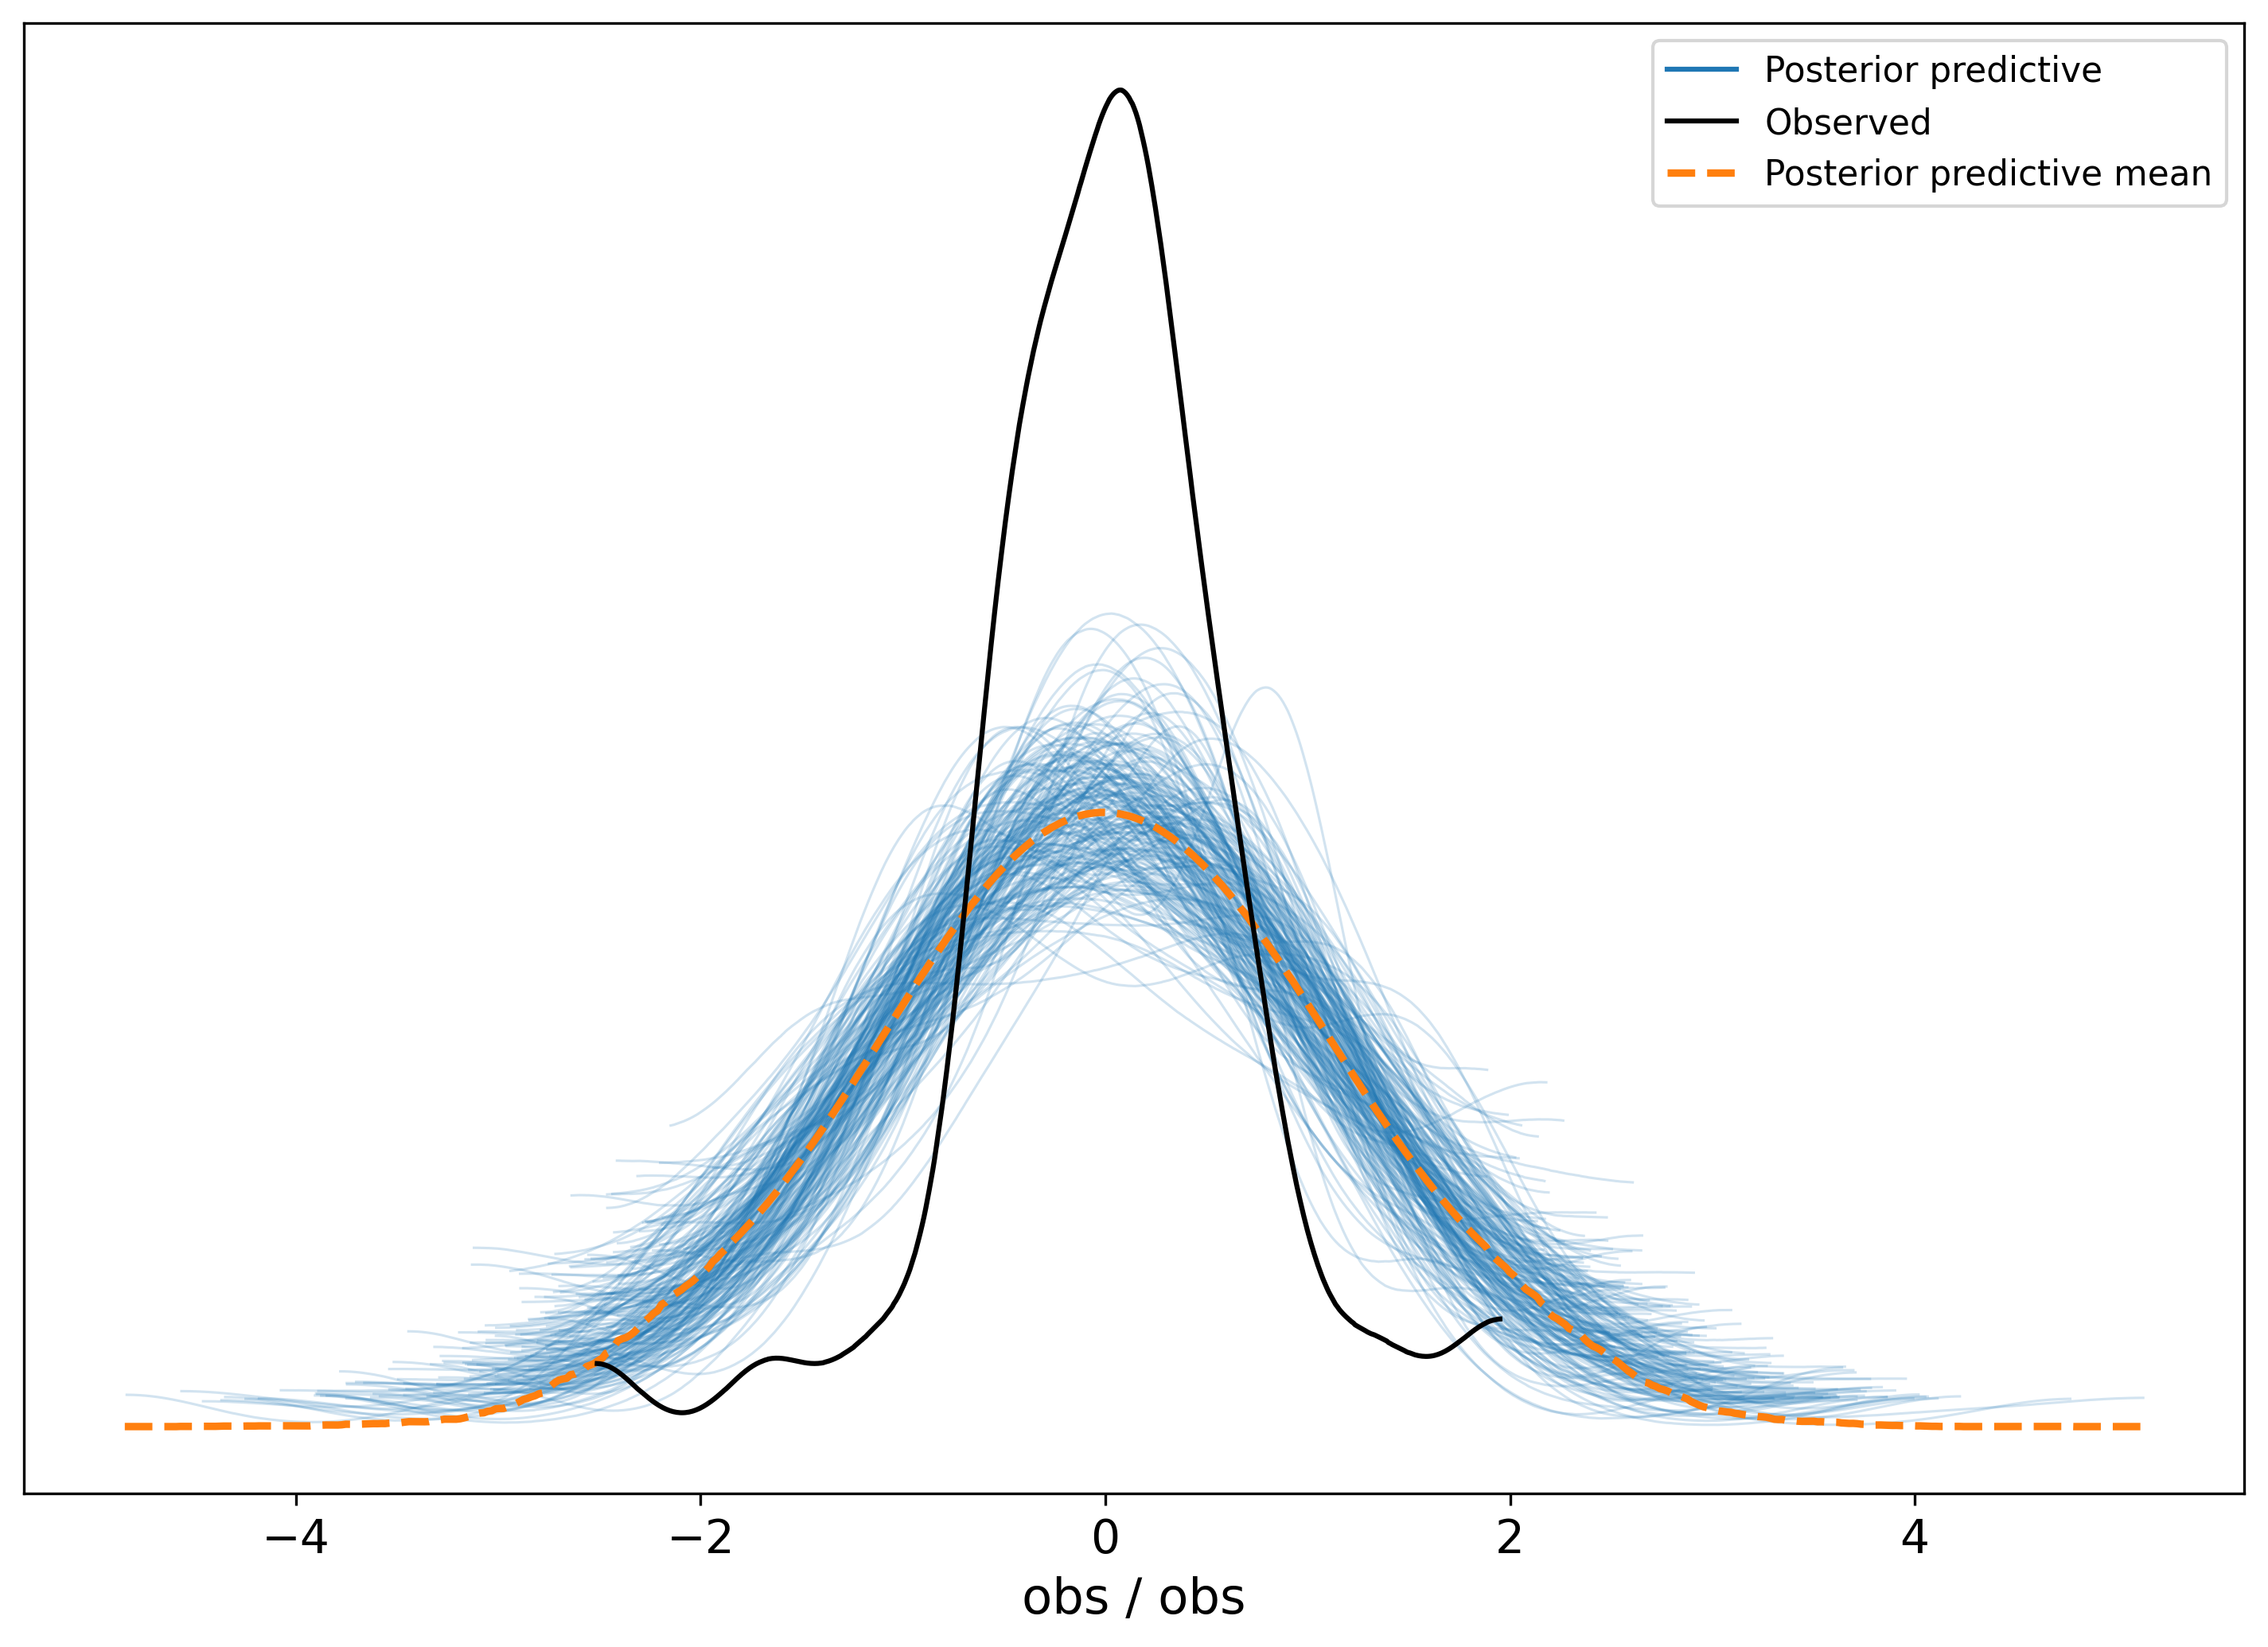

In [11]:
_ = az.plot_ppc(idata, num_pp_samples=200)